# Commercial Loan (Startup Lending) Analysis Model

The model is designed to simulate loan repayment schedules and assess the Internal Rate of Return (IRR) under various default risk scenarios. This model aids in evaluating the financial viability of commercial loans and understanding the impact of defaults over time.

## Setup

In [6]:
from dataclasses import dataclass  # For creating structured data classes
import numpy_financial as npf      # For financial calculations like IRR
import pandas as pd                # For data manipulation and storage
import matplotlib.pyplot as plt    # For visualizing results
import random                      # For generating random cases
import itertools                   # For handling parameter combinations
import matplotlib.colors as mcolors  # For customizing plot aesthetics


## Inputs

In [7]:
@dataclass
class ModelInputs:
    """
    Represents the input parameters for the Commercial Loan Analysis Model.
    - price_machine: The principal loan amount for purchasing machinery.
    - loan_life: The duration of the loan in years (tuple of options).
    - initial_default: Initial default probability in the first year (tuple of options).
    - default_decay: Rate at which default risk decreases over time.
    - final_default: Default probability in the final year.
    - recovery_rate: Percentage of the loan amount recovered after a default.
    - interest: Annual interest rate (tuple of options).
    - num_iterations: Number of Monte Carlo iterations for simulations.
    - case_names: Names of possible cases (Fulfillment and Default).
    """
    price_machine: float = 1_000_000
    loan_life: tuple = (5, 10, 20)
    initial_default: tuple = (0.1, 0.2, 0.3)
    default_decay: float = 0.9
    final_default: float = 0.4
    recovery_rate: float = 0.4
    interest: tuple = (0.3, 0.35, 0.4)
    num_iterations: int = 1000
    case_names: tuple = ('Fulfillment', 'Default')

        
model_data = ModelInputs()

## Model

### Utility Functions

In [8]:
def default_risk_at_year(data: ModelInputs, year):
    """
    Gets the default risk at a given year with its decreases overtime as the business matures. There is a high probability of default in the final year due to the payment of principle and interest.
    """
    if year < data.loan_life:
        if year == 1:
            default_probability = data.initial_default
        else:
            default_probability = default_risk_at_year (data, year-1) * data.default_decay
    else:
        default_probability = data.final_default
    return default_probability

In [9]:
def get_the_payment_case (data: ModelInputs, year):
    """
    Internal Randomness
    - 0: fulfillment 
    - 1: default
    As this aligns with how the inputs are defined, the function will return the case number.
    """
    case_num = random.choices([0,1], weights = [1- default_risk_at_year(data, year), default_risk_at_year(data, year)])[0]
    return case_num

In [10]:
def loan_repayment_at_year(data: ModelInputs, year):
    """
    Gets the loan repayment at a given year from the start of the model based on machine price and interest rate.
    """
    if year < data.loan_life:
        # For n-1 years, the business is responsible for paying the interst.
        CF_at_year = data.price_machine * data.interest
    else:
        # In the final period, both machine price and interest will be paid.
        CF_at_year = data.price_machine * (1 + data.interest)
    return CF_at_year

### Core Model Functions

In [32]:
def loan_assessment (data: ModelInputs, print_output = True):
    """
    The main model function which the internal rate of return based on the model inputs,
    calling the other functions to determine the loan repayment and default probability.
    """
    year = 0
    CF = [-data.price_machine]

    if print_output:
        print ('Loan Schedule:')
        print('Interest rate: {data.interest}, Loan life: {data.loan_life}, Initial default probability: {data.initial_default}')
    while year < data.loan_life :
        year +=1
        default_risk = default_risk_at_year(data, year)
        case = get_the_payment_case(data, year)
        case_type = data.case_names[case]
        # Handling the CF during the loan repayment schedule 
        if case == 0:
            loan_repayment = loan_repayment_at_year(data, year)
            CF.append(loan_repayment)
            if print_output:
                print(f'The loan repayment at year {year} ({case_type}) is ${loan_repayment:,.0f}.') 
        else:
            recovery_amount = data.recovery_rate * data.price_machine
            CF += [0, 0, recovery_amount]
            if print_output:
                print(f'The loan is in {case_type} at year {year}.')
                print(f'There are no interests collected for year {year} and {year + 1}.')
                print(f'The recovery amount collected at year {year + 2} is ${recovery_amount:,.0f}.')
            break

    irr = npf.irr(CF)
    if print_output:
        print(f'\nIRR: The effective interest rate at which the loan payments are valued is: {irr * 100:,.2f}%.')
    return irr

### Interation & Scenario Analysis Functions

In [12]:
def simulate_loan_interations_df(data: ModelInputs):
    """
    Runs the model repeatedly based on the number of iterations and puts the resulting
    IRR in a DataFrame
    """
    all_irrs = []
    interest_rate = []
    loan_life = []
    initial_default = []
    
    for i in range(data.num_iterations):
        irr = loan_assessment(data, print_output=False)
        all_irrs.append(irr)
        interest_rate.append(data.interest)
        loan_life.append(data.loan_life)
        initial_default.append(data.initial_default)

    irr_df = pd.DataFrame()
    irr_df['Interest Rate'] = [f"{rate * 100:.0f}%" for rate in interest_rate]
    irr_df['Loan Life'] = loan_life
    irr_df['Initial Default Probability'] = [f"{prob * 100:.0f}%" for prob in initial_default]
    irr_df['IRR'] = [f"{rate * 100:.2f}%" for rate in all_irrs]
    return irr_df

In [20]:
def simulate_scenario_results(data):
    combinations = tuple(itertools.product(data.interest, data.loan_life, data.initial_default))
    results_df = pd.DataFrame()

    for comb in combinations:
        interest, loan_life, initial_default = comb
        data = ModelInputs(interest = interest, loan_life = loan_life, initial_default = initial_default)
        irr_df= simulate_loan_interations_df(data)
        results_df = pd.concat([results_df, irr_df], ignore_index=True)
    
    return results_df

## Output

In [23]:
irr_df = simulate_scenario_results(model_data)
print (irr_df)

      Interest Rate  Loan Life Initial Default Probability      IRR
0               30%          5                         10%   30.00%
1               30%          5                         10%    8.92%
2               30%          5                         10%   30.00%
3               30%          5                         10%   15.26%
4               30%          5                         10%   15.26%
...             ...        ...                         ...      ...
26995           40%         20                         30%    7.36%
26996           40%         20                         30%   -8.24%
26997           40%         20                         30%  -26.32%
26998           40%         20                         30%   31.10%
26999           40%         20                         30%  -26.32%

[27000 rows x 4 columns]


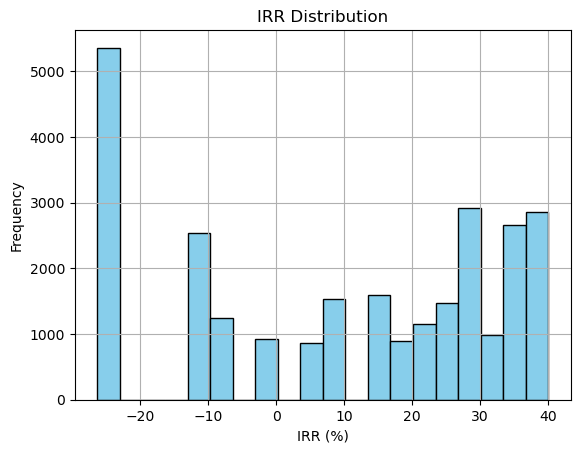

In [25]:
def plot_irr_distribution(irr_df: pd.DataFrame):
    irr_df['IRR_numeric'] = irr_df['IRR'].str.rstrip('%').astype(float)
    irr_df['IRR_numeric'].hist(bins=20, color='skyblue', edgecolor='black')
    plt.title('IRR Distribution')
    plt.xlabel('IRR (%)')
    plt.ylabel('Frequency')
    plt.show()

plot_irr_distribution(irr_df)

In [31]:
print(f"Mean IRR: {irr_df['IRR_numeric'].mean():.2f}%")
print(f"Median IRR: {irr_df['IRR_numeric'].median():.2f}%")
print(f"Standard Deviation: {irr_df['IRR_numeric'].std():.2f}%")
print(f"Max IRR: {irr_df['IRR_numeric'].max():.2f}%")
print(f"Min IRR: {irr_df['IRR_numeric'].min():.2f}%")

Mean IRR: 9.72%
Median IRR: 15.26%
Standard Deviation: 23.63%
Max IRR: 40.00%
Min IRR: -26.32%
